## Analysis of NP GNPS library positive mode 

This is a data obtained from (https://external.gnps2.org/gnpslibrary)

In [1]:
import os
os.chdir("..")
print(os.getcwd())

from matchms.importing import load_from_mgf

/Users/rosinatorres/Documents/PhD/Project/Code/MS2LDA/MS2LDA


In [2]:
from rdkit.Chem.inchi import MolFromInchi
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.inchi import InchiToInchiKey

fpgen = AllChem.GetRDKitFPGenerator()

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

### Loading the dataset into matchms

In [4]:
# Loading the dataset into matchms
spectra_path = "test_data/GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE.mgf"
spectra = list(load_from_mgf(spectra_path))

In [7]:
# retrieving inchis from spectra to convert them into rdkit.mol.objects
inchis = []
nominal_masses = []
inchis_key = []
for spectrum in spectra:
    inchi = spectrum.get("inchi")
    inchis.append(inchi)
    inchi_key = InchiToInchiKey(inchi)
    inchis_key.append(inchi_key)
    nominal_mass = spectrum.get("precursor_mz")
    nominal_masses.append(int(nominal_mass))

In [8]:
mols = [MolFromInchi(inchi) for inchi in inchis]

In [9]:
print(len(mols))

7915


### Mass distribution

Below you can see the mass distribution of the compounds in the dataset.

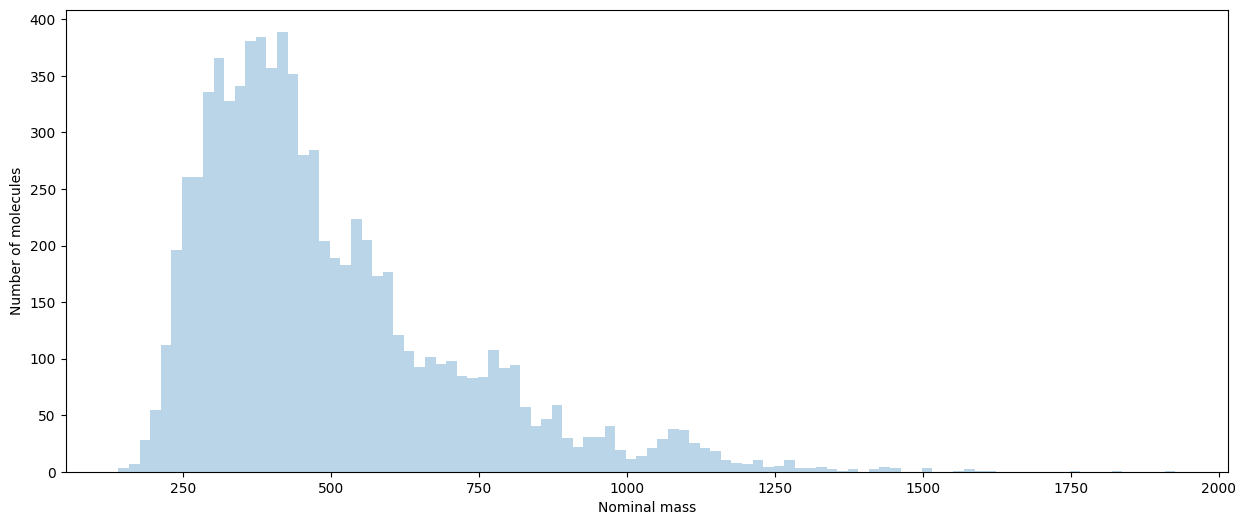

In [10]:
plt.figure(figsize=(15,6))
plt.hist(nominal_masses, bins=100, alpha=0.3)
plt.xlabel("Nominal mass")
plt.ylabel("Number of molecules")
plt.show()

### Mol similarity based on fingerprints

In the following section fingerprints of all molecules in the dataset are generated and then the tanimoto score of all pairs (AB only, not AB and BA) are calculated and visualized in a histogram.

In [11]:
# standard rdkit fingperprints (default with 1024 bits)
fps = [fpgen.GetFingerprint(mol) for mol in mols]

In [12]:
from itertools import combinations

In [13]:
# two pair fingerprint combinations
fps_combinations = combinations(fps, 2)

In [14]:
# calculation of tanimoto scores
tanimoto_scores = []
for fp1, fp2 in fps_combinations:
    tanimoto_score = DataStructs.TanimotoSimilarity(fp1,fp2)
    tanimoto_scores.append(tanimoto_score)

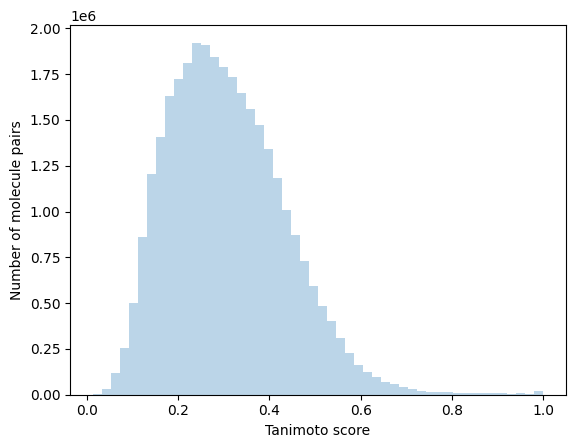

In [15]:
plt.hist(tanimoto_scores, bins=50, alpha=0.3)
plt.xlabel("Tanimoto score")
plt.xlabel("Tanimoto score")
plt.ylabel("Number of molecule pairs")
plt.show()

### Most common Murcko framework

In the following section the Murcko framework is used to show the structural diversity of the dataset. The Murcko framwork captures the "core" scaffold of a compound discharging all branches of a molecule. See explanation and examples here: https://datagrok.ai/help/datagrok/solutions/domains/chem/scripts/murcko-scaffolds

In [16]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from collections import Counter
from rdkit.Chem import Draw
from rdkit import Chem

In [17]:
c = Counter()
for mol in mols:
    scaffold_mol = GetScaffoldForMol(mol)
    scaffold_smiles = Chem.MolToSmiles(scaffold_mol)
    c[scaffold_smiles] += 1

/Users/rosinatorres/anaconda3/envs/MS2LDA_v2/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


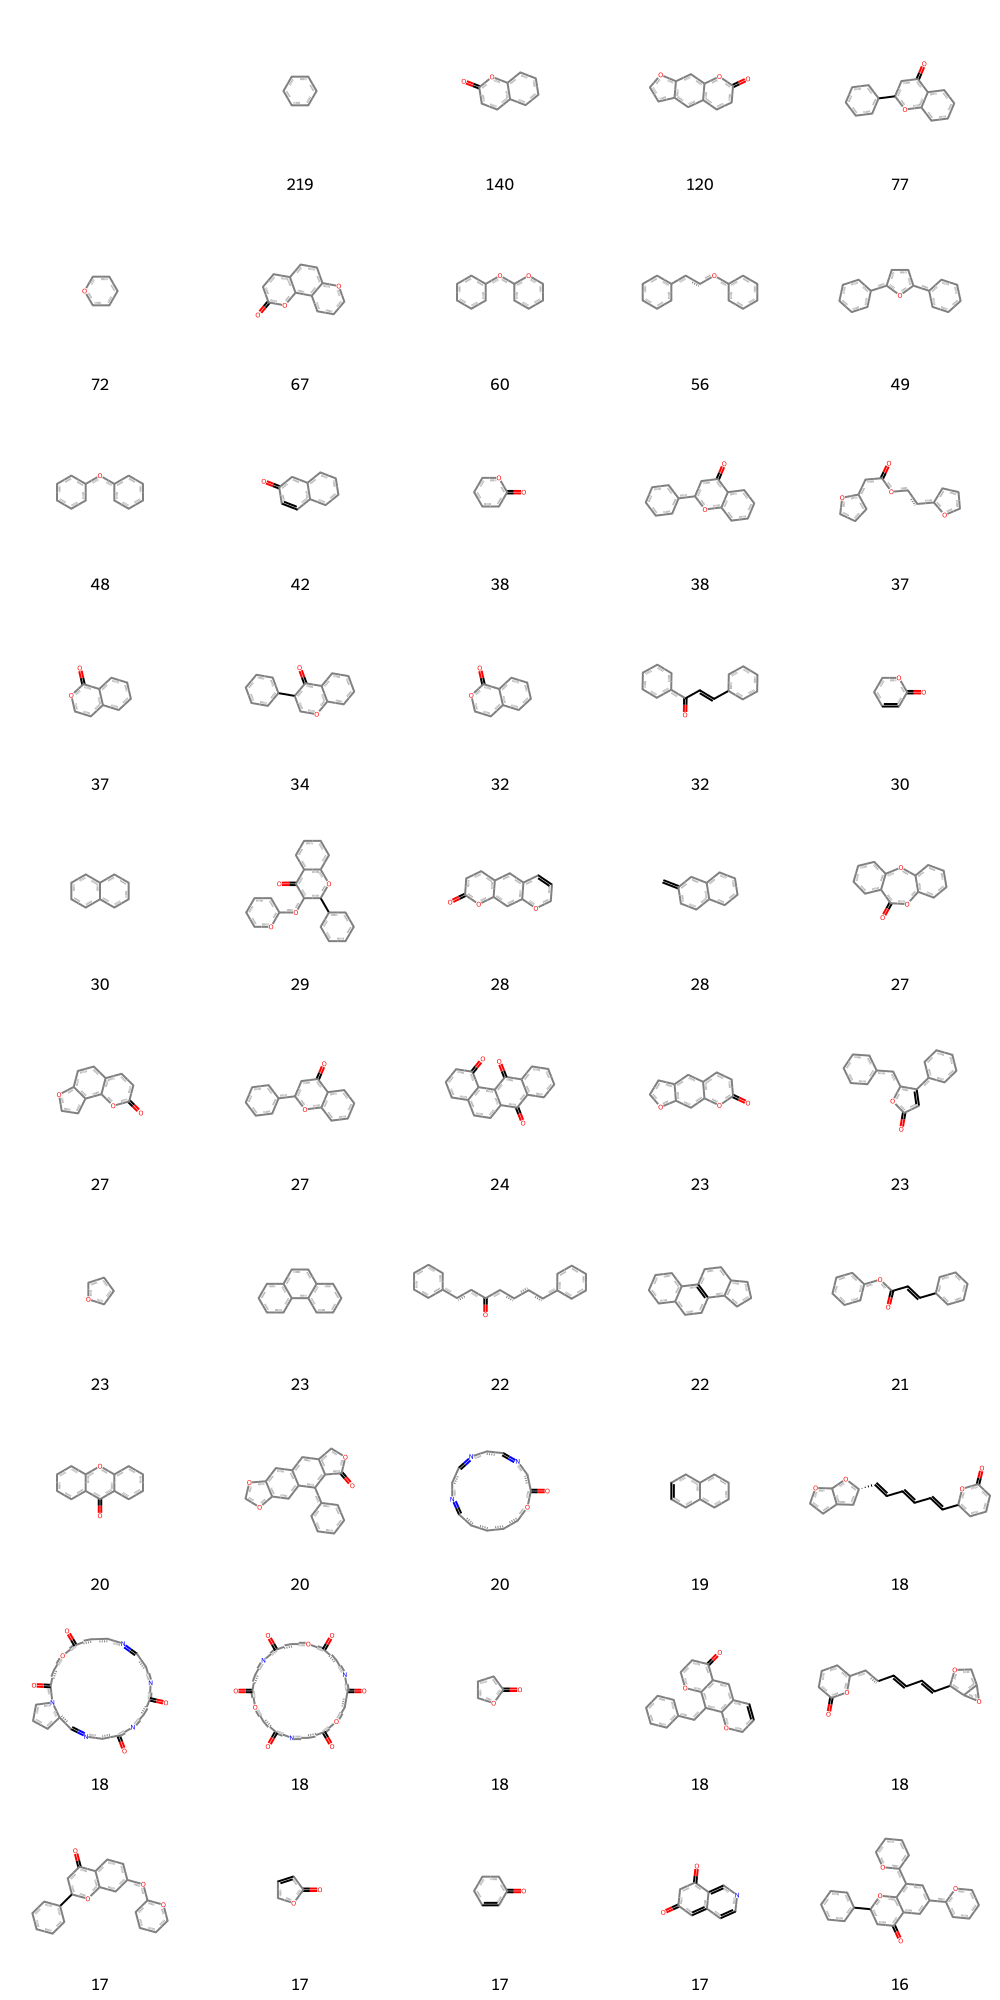

In [18]:
Draw.MolsToGridImage([Chem.MolFromSmarts(smarts) for smarts, count in list(c.most_common())], molsPerRow=5, legends=[str(count) for smarts, count in list(c.most_common())])

### ERTL functional groups

In the following section you can find the most common functional groups in the dataset (ERTL functional group finder).

In [19]:
import sys
from rdkit import RDPaths
ifg_path = os.path.join(RDPaths.RDContribDir, "IFG")
sys.path.append(ifg_path)
import ifg

In [20]:
fgs = Counter()
for mol in mols:
    fgs_per_mol = ifg.identify_functional_groups(mol)
    seen_fgs = set()
    for fg in fgs_per_mol:
        atoms = fg.atoms
        if atoms not in seen_fgs and len(atoms) > 1:
            fgs[atoms] += 1
            seen_fgs.add(atoms)

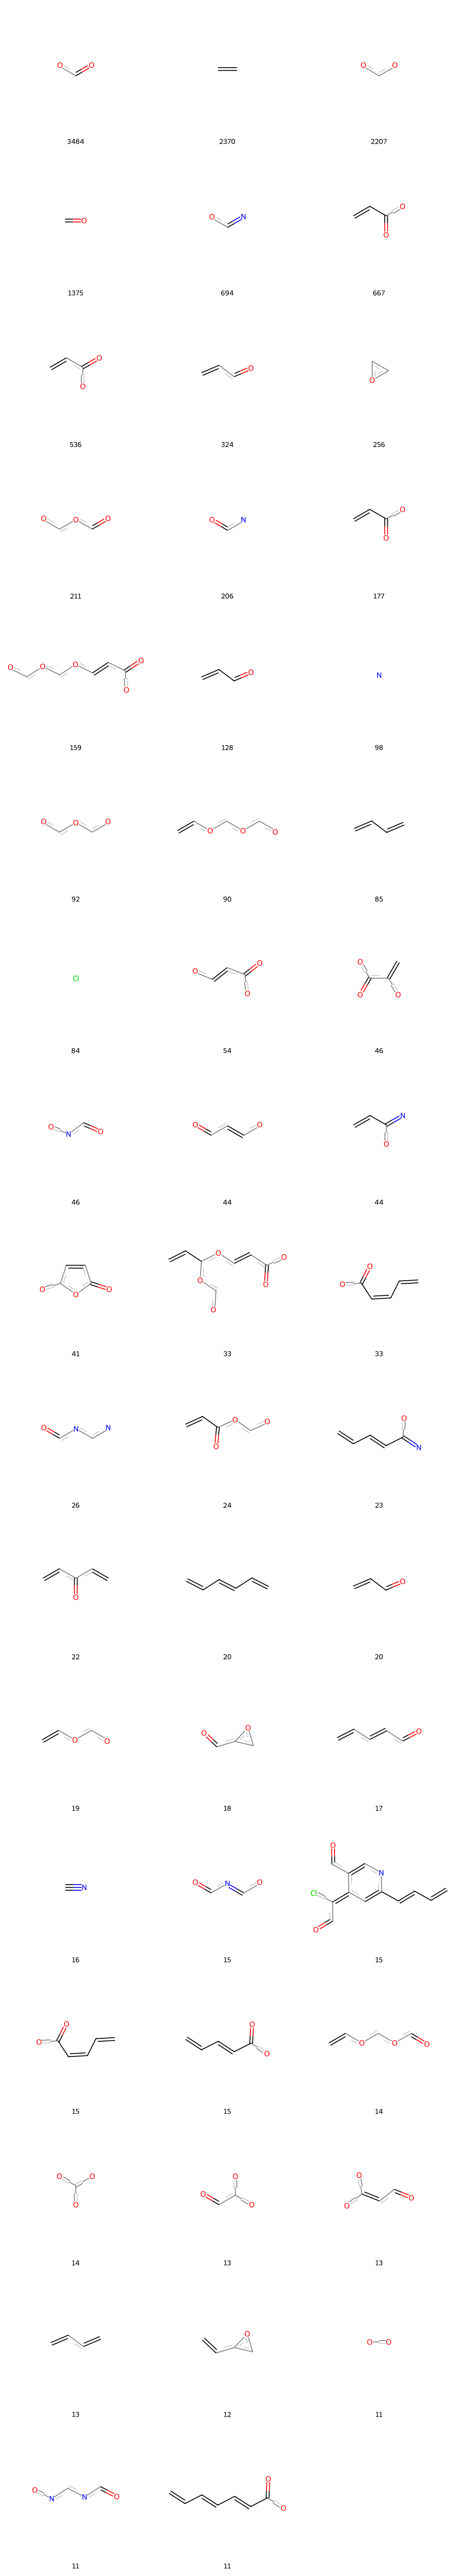

In [21]:
Draw.MolsToGridImage([Chem.MolFromSmarts(smarts) for smarts, count in list(fgs.most_common())], molsPerRow=3, legends=[str(count) for smarts, count in list(fgs.most_common())], subImgSize=(350, 350))

## Spectral Similarities

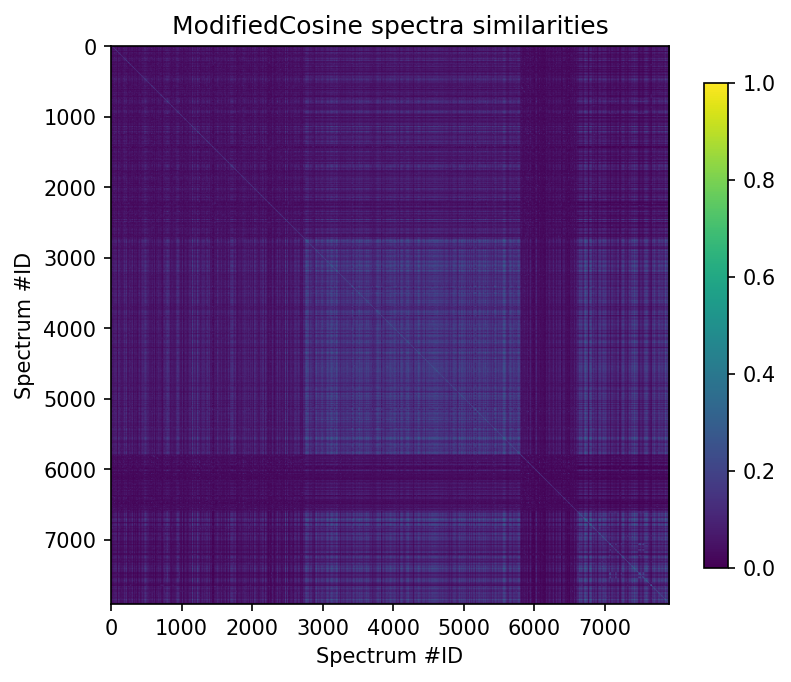

In [22]:
from matchms import calculate_scores
from matchms.similarity import ModifiedCosine

similarity_measure = ModifiedCosine(tolerance=0.005)

# Calculate scores
scores = calculate_scores(spectra, spectra, similarity_measure, is_symmetric=True)

# Get score names
score_names = scores.score_names

# Convert sparse score array to Numpy array
scores_array = scores.scores.to_array()

# Extract the desired field for plotting
scores_array = scores_array['ModifiedCosine_score']

# Plot the scores
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array, cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("ModifiedCosine spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.show()

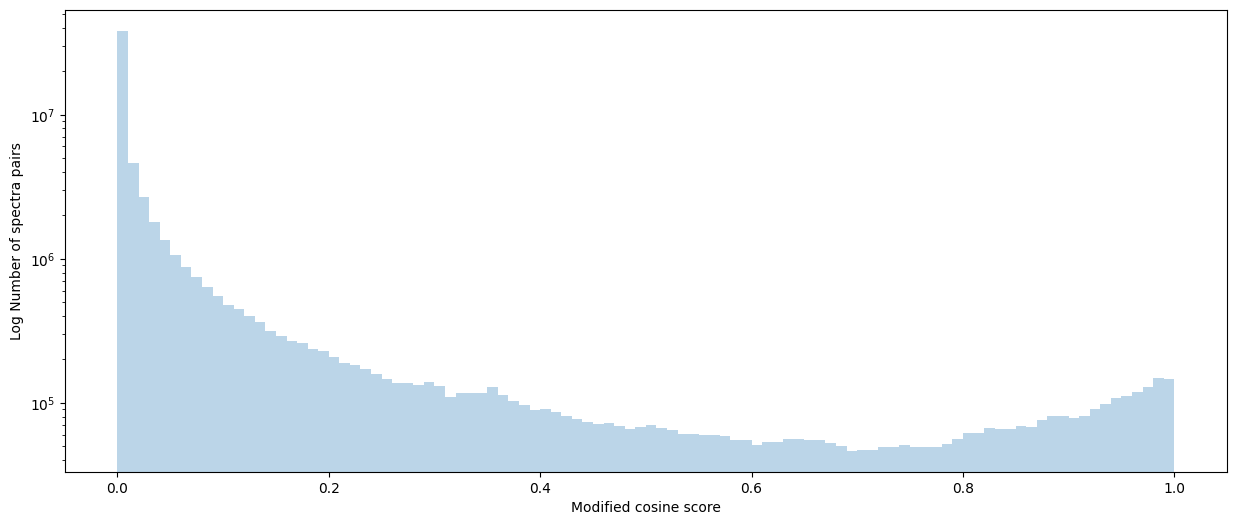

In [26]:
scores_list = scores_array.flatten().tolist()
plt.figure(figsize=(15,6))
plt.hist(scores_list, bins=100, alpha=0.3)
plt.xlabel("Modified cosine score")
plt.yscale("log")
plt.ylabel("Log Number of spectra pairs")
# Invert both x and y axes
plt.show()

## Chemical Class Classification

In [27]:
from ms2query.create_new_library.add_classifire_classifications import get_json_cf_results
from ms2query.create_new_library.add_classifire_classifications import convert_to_dataframe

In [28]:
classyfire_results = [get_json_cf_results(inchi_key) for inchi_key in inchis_key]

ConnectionResetError: [Errno 54] Connection reset by peer

In [ ]:
second_level_class = [result[2] if result else "No label" for result in classyfire_results]

In [ ]:
from collections import Counter
c = Counter()
for class_ in second_level_class:
    if class_ != "No label":
        c[class_] += 1

In [ ]:
classes = [element for element, count in c.most_common()]
count = [count for element, count in c.most_common()]

custom_palette = sns.color_palette("husl", len(list(c)))

plt.figure(figsize=(10, 6))
plt.bar(classes, count, color=custom_palette)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.ylabel('Count')
plt.title('Distribution of cf_class')
plt.tight_layout()
plt.show()